In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
torch.cuda.set_device(0)
import os
from pathlib import Path
import json
from fastai import *
from fastai.dataset import *
from fastai.conv_learner import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import patheffects

## Load Data

In [3]:
data_dir = Path('/mnt/data/extracts/pascal')
JPEGS = data_dir/'VOCdevkit/VOC2007/JPEGImages/'

In [4]:
train = json.load(open(data_dir/'pascal_train2007.json'))
val = json.load(open(data_dir/'pascal_val2007.json'))
test = json.load(open(data_dir/'pascal_test2007.json'))

### Create File Lookups

In [5]:
all_images = train['images'] + val['images'] + test['images']
fnid = {x['file_name']: x['id'] for x in all_images}


### Create DataFrames

In [6]:
def bb_np(bbox_hw):
    return [bbox_hw[1], bbox_hw[0], 
            bbox_hw[1] + bbox_hw[3], 
            bbox_hw[0] + bbox_hw[2]]

def bb_hw(bbox_np):
    return [bbox_np[1], bbox_np[0], 
            bbox_np[3] - bbox_np[1],
            bbox_np[2] - bbox_np[0]]

def create_df(d):
    anno = d['annotations']
    fnid = [{'file_name': x['file_name'], 'image_id': x['id']} for x in d['images']]
    cats = [{'category_id': x['id'], 'category_name': x['name']} for x in d['categories']]
    anno_df = pd.DataFrame.from_dict(anno)
    fname_df = pd.DataFrame.from_dict(fnid)
    cat_df = pd.DataFrame(cats)
    df = pd.merge(anno_df, cat_df, how='inner', on='category_id')
    df = pd.merge(df, fname_df, how='inner', on='image_id')
    df['bbox_np'] = df['bbox'].apply(lambda x: bb_np(x))
    df = df.loc[df.ignore != 1]
    return df

def get_largest(df):
    return df.sort_values('area', ascending=False).groupby(['image_id']).first().reset_index()

In [7]:
train_df = create_df(train)
val_df = create_df(val)
test_df = create_df(test)
comb_df = pd.concat([train_df, val_df], axis=0)

In [8]:
trn_lrg_df = get_largest(train_df)
val_lrg_df = get_largest(val_df)
comb_lrg_df = get_largest(comb_df)

### Setup Plotting functions

In [9]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_anno(ax, x, y, anno):
    text = ax.text(x, y, anno, fontsize=14, color='white', weight='bold', 
                   verticalalignment='top')
    draw_outline(text, 1)
    
def draw_rect(ax, bbox):
    x = bbox[0]
    y = bbox[1]
    h = bbox[2]
    w = bbox[3]
    ax.add_patch(patches.Rectangle((x, y), h, w, fill=False, edgecolor='white', lw=2))
    
def show_img(img, ax=None, figsize=(16, 8)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    return ax
    
def plot_idx(image_id, figsize=(16, 8)):
    rel = comb_lrg_df.loc[comb_lrg_df.image_id == image_id].iloc[0]
    fname = rel.file_name
    cat = rel.category_name
    bbox = rel.bbox
    f_path = JPEGS/fname
    img = open_image(f_path)
    ax = show_img(img, figsize=figsize)
    draw_rect(ax, bbox)
    draw_anno(ax, bbox[0], bbox[1], cat)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

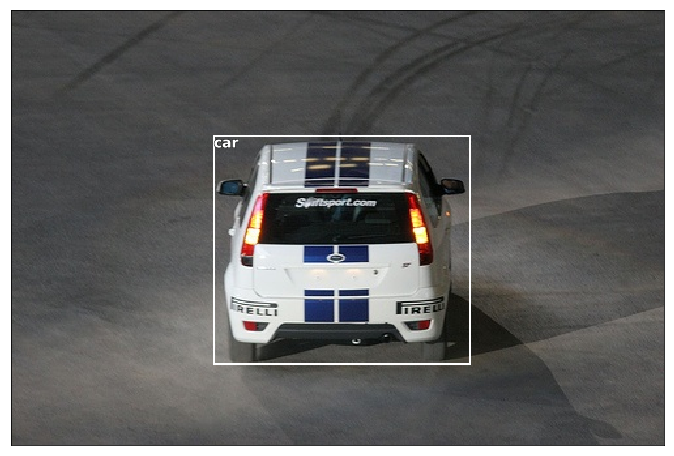

In [10]:
plot_idx(12)

## Setup Convolutional Model

In [10]:
f_model = resnet34
TMP = data_dir/'tmp'
TMP.mkdir(exist_ok=True)
CSV = Path(TMP/'train.csv')
MODEL = Path('/mnt/models/pascal')
pd.DataFrame({'fn': train_df.file_name, 'cat': train_df.category_name},
             columns=['fn', 'cat']).to_csv(CSV, index=False)
sz = 224

In [12]:
tfms = tfms_from_model(f_model, sz=sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(MODEL, JPEGS, CSV, skip_header=True, tfms=tfms)

In [13]:
learn = ConvLearner.pretrained(f_model, md)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ubuntu/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 70431333.17it/s]


In [14]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 93%|█████████▎| 92/99 [00:41<00:03,  2.20it/s, loss=16.2]

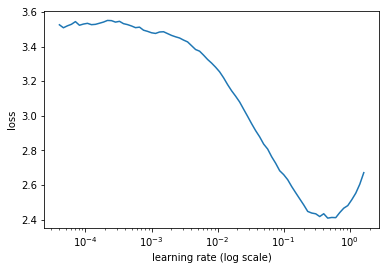

In [15]:
learn.sched.plot()
lr = 2*1e-2

In [16]:
learn.fit(lr, n_cycle=1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 13%|█▎        | 13/99 [00:07<00:48,  1.77it/s, loss=3.05]

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                 
    0      1.280371   0.871415   0.75      



[0.8714151, 0.75]

In [19]:
learn.precompute = False
learn.fit(lr, n_cycle=2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.989096   0.68519    0.785625  
    1      0.811806   0.529306   0.84                      
    2      0.664214   0.481109   0.865625                  



[0.48110884, 0.865625]

In [54]:
x, y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x, probs = to_np(x), to_np(probs)
preds = np.argmax(probs, -1)

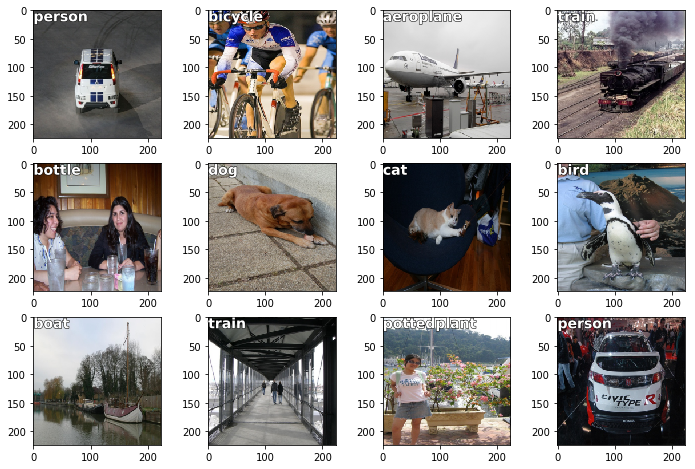

In [58]:
fig, axis = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axis.flat):
    img = np.squeeze(md.val_ds.denorm(x[i]))
    cls = md.classes[preds[i]]
    show_img(img, ax, figsize=(12, 8))
    draw_anno(ax, 0, 0, cls)

## Build BBox Model

In [11]:
BB_CSV = TMP/'BB.CSV'
def get_bb(x):
    y = [str(i) for i in x]
    return ' '.join(y)

bb_df = trn_lrg_df[['file_name', 'bbox_np']].copy()
bb_df['bbox_np'] = bb_df['bbox_np'].apply(lambda x: get_bb(x))
bb_df.to_csv(BB_CSV, index=False)

In [12]:
sz = 224
f_model = resnet34
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y, p=0.5),
        RandomRotate(3, p=0.5, tfm_y=tfm_y),
        RandomLighting(0.05, 0.05, tfm_y=tfm_y)]
tfms = tfms_from_model(f_model, sz=sz, aug_tfms=augs, max_zoom=1.1, 
                       tfm_y=tfm_y, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(MODEL, JPEGS, BB_CSV, tfms=tfms, skip_header=True, continuous=True)

In [204]:
head = nn.Sequential(Flatten(), nn.Linear(25088, 4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [192]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 44%|████▍     | 14/32 [00:08<00:10,  1.71it/s, loss=103]


Exception in thread Thread-9:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 94%|█████████▍| 30/32 [00:14<00:00,  2.00it/s, loss=451] 


In [205]:
learn.sched.plot()
lr = 2e-3

In [206]:
learn.fit(lr, n_cycle=4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      41.715664  29.766874 
    1      32.181816  27.898115                           
    2      27.608795  25.907803                           
    3      24.970203  25.594484                           



[25.594484]

In [207]:
lrs = np.array([lr/100,lr/10,lr])

In [208]:
learn.freeze_to(-2)

In [209]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 94%|█████████▍| 30/32 [00:21<00:01,  1.41it/s, loss=103] 

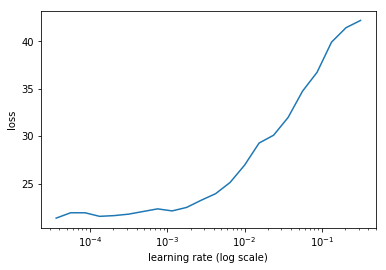

In [212]:
learn.sched.plot(n_skip=3)

In [213]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

 16%|█▌        | 5/32 [00:05<00:31,  1.17s/it, loss=27.8]


Exception in thread Thread-22:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                            
    0      24.495201  23.738144 
    1      22.111918  24.510054                           
    2      18.074953  21.624294                           



[21.624294]

In [214]:
learn.freeze_to(-3)
learn.fit(lrs, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      16.267414  22.832348 
    1      15.132302  21.220909                           



[21.22091]

In [218]:
x, y = next(iter(md.val_dl))
pred = predict_batch(learn.model, x)
x, pred = to_np(x), to_np(pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


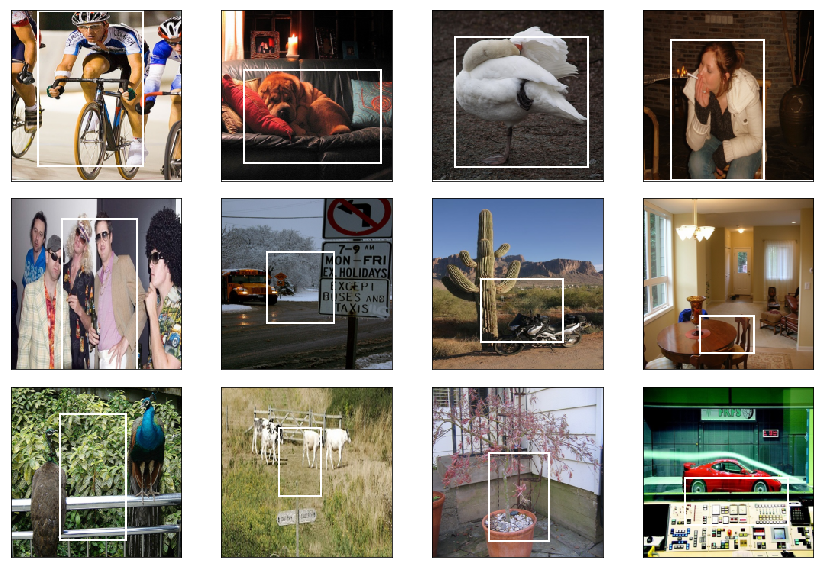

In [222]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    show_img(np.squeeze(md.val_ds.denorm(x[i])), ax)
    draw_rect(ax, bb_hw(pred[i]))
plt.tight_layout()

## Build BBox and Classification

In [36]:
sz = 224
f_model = resnet34
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y, p=0.5),
        RandomRotate(3, tfm_y=tfm_y),
        RandomLighting(0.05, 0.05, tfm_y=tfm_y)]
tfms = tfms_from_model(f_model, sz=sz, aug_tfms=augs, crop_type=CropType.NO, tfm_y=tfm_y)
md_bb = ImageClassifierData.from_csv(MODEL, JPEGS, BB_CSV, tfms=tfms,
                                     continuous=True, skip_header=True)
md_cl = ImageClassifierData.from_csv(MODEL, JPEGS, CSV, tfms=tfms, skip_header=True)

In [37]:
class ConcatDataSet(Dataset):
    def __init__(self, ds1, y2):
        self.ds1 = ds1
        self.y2 = y2
    
    def __len__(self):
        return len(self.ds1)
    
    def __getitem__(self, i):
        x1, y1 = self.ds1[i]
        return (x1, (y1, self.y2[i]))

In [38]:
comb_trn_ds = ConcatDataSet(md_bb.trn_ds, md_cl.trn_y)
comb_val_ds = ConcatDataSet(md_bb.val_ds, md_cl.val_y)

In [39]:
md_bb.trn_dl.dataset = comb_trn_ds
md_bb.val_dl.dataset = comb_val_ds

In [40]:
head = nn.Sequential(Flatten(),
                     nn.ReLU(),
                     nn.Dropout(0.5),
                     nn.Linear(25088, 256),
                     nn.ReLU(),
                     nn.BatchNorm1d(256),
                     nn.Dropout(0.5),
                     nn.Linear(256, 4 + len(md_cl.classes))
                    )

model = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head)
learn = ConvLearner(md_bb, model)
learn.opt_fn = optim.Adam

In [41]:
def calc_loss(output, target):
    bb_loss = calc_bb_loss(output, target)
    cl_loss = calc_cl_loss(output, target)
    return bb_loss + 20*cl_loss
    
def calc_bb_loss(output, target, var=False):
    bb_o, c_o = output[:, :4], output[: ,4:]
    bb_t, c_t = target
    bb_o = F.sigmoid(bb_o)*224
    if var:
        loss = F.l1_loss(V(bb_o), V(bb_t))
    else:
        loss = F.l1_loss(bb_o, bb_t)
    return loss

def calc_cl_loss(output, target, var=False):
    bb_o, c_o = output[:, :4], output[:, 4:]
    bb_t, c_t = target
    if var:
        loss = F.cross_entropy(V(c_o), V(c_t))
    else:
        loss = F.cross_entropy(c_o, c_t)
    return loss
    
def bb_loss_metric(output, target):
    bb_loss = calc_bb_loss(output, target, True)
    return bb_loss.data

def cl_loss_metric(output, target):
    cl_loss = calc_cl_loss(output, target, True)
    return cl_loss.data

In [42]:
class FeatureExtractor(nn.Module):
    def __init__(self, orig_model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(orig_model.children())[:-1])
    
    def forward(self, x):
        if isinstance(x, torch.autograd.variable.Variable):
            x = self.features(x)
        else:
            x = self.features(V(x))
        return x

ff = FeatureExtractor(learn.model)
x, y = next(iter(md_bb.val_dl))
a = ff(x)

In [43]:
learn.crit = calc_loss
learn.metrics = [bb_loss_metric, cl_loss_metric]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 94%|█████████▍| 30/32 [00:16<00:01,  1.87it/s, loss=663]

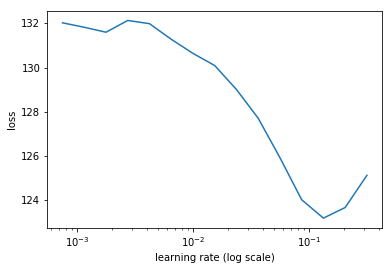

In [44]:
learn.lr_find()
learn.sched.plot()
lr = 1e-2

In [45]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

 25%|██▌       | 8/32 [00:06<00:19,  1.23it/s, loss=127] 


Exception in thread Thread-12:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   bb_loss_metric cl_loss_metric 
    0      105.085653 88.74131   29.394991  2.967316  
    1      91.239439  82.962585  24.984444  2.898907      
    2      85.060829  82.081734  24.416941  2.88324       



[82.08173, 24.41694, 2.8832395]

## Check

In [13]:
f_model=resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(trn_lrg_df.file_name))

In [14]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(MODEL, JPEGS, BB_CSV, tfms=tfms,
    continuous=True)

In [15]:
md2 = ImageClassifierData.from_csv(MODEL, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

In [16]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [17]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [18]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [19]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(md.classes)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [20]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 91%|█████████ | 29/32 [00:15<00:01,  1.81it/s, loss=788]

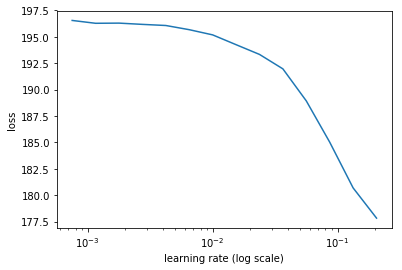

In [21]:
learn.lr_find()
learn.sched.plot()

In [22]:
lr=1e-2

In [23]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

 47%|████▋     | 15/32 [00:09<00:10,  1.58it/s, loss=187]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   detn_acc   detn_l1      
    0      142.055669 94.880989  0.114183   32.993737 
    1      105.509352 84.508629  0.117488   25.843315    
    2      91.792697  84.876633  0.133113   24.794428     



[84.87663, 0.13311298098415136, 24.79442811012268]